<h2 style="text-align: center;"><b>Практическое задание: Архитектуры и Transfer Learning</b></h3>

В данном ноутбуке мы поближе познакомимся с архитектурами *AlexNet*, *VGG* и *Inception (GoogleNet)*, и для каждой из этих моделей используем технику **Transfer Learning**. 

1. **Feature Extractor** способ:
    * Берём **уже обученную** нейросеть
    * **Убираем последние полносвязные слои** сети, отвечающие за классификацию
    * Ставим вместо них **свои слои классификации** (например, 2 полносвязных слоя), веса этих слоев **будут меняться во время обучения**
    * Веса всех свёрточных слоёв **заморожены**, то есть во время обучения сети они **меняться не будут**
    * **Обучаем** всю сеть (меняются только слои классификации) на новом датасете 
    * Используем полученную модель для предсказания
2. **Fine Tuning** способ:  
    * Берём **уже обученную** нейросеть
    * **Убираем последние полносвязные слои** сети, отвечающие за классификацию
    * Ставим вместо них **свои слои классификации** (например, 2 полносвязных слоя), веса этих слоев **будут меняться во время обучения**
    * Веса всех свёрточных слоёв **разморожены**, то есть во время обучения сети они **будут меняться**
    * **Обучаем** всю сеть (меняются веса всех слоев) на новом датасете 
    * Используем полученную модель для предсказания

Практическую часть ноутбука крайне рекомендуется выпонять в сервисе [Google Colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true). В нем **обязательно** нужно поставить `Runtime -> Change Runtime Type -> GPU`:

In [0]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os

plt.ion()

### Функции для отрисовки и обучения модели:

* Загрузим данные:

In [2]:
!wget https://download.pytorch.org/tutorial/hymenoptera_data.zip

--2020-06-06 19:43:13--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 99.86.33.87, 99.86.33.48, 99.86.33.64, ...
Connecting to download.pytorch.org (download.pytorch.org)|99.86.33.87|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M  23.9MB/s    in 1.9s    

2020-06-06 19:43:15 (23.9 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]



In [3]:
!unzip ./hymenoptera_data.zip

Archive:  ./hymenoptera_data.zip
   creating: hymenoptera_data/
   creating: hymenoptera_data/train/
   creating: hymenoptera_data/train/ants/
  inflating: hymenoptera_data/train/ants/0013035.jpg  
  inflating: hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: hymenoptera_data/train/ants/1099452230_d1949d3250.jpg  
  inflating: hymenoptera_data/train/ants/116570827_e9c126745d.jpg  
  inflating: hymenoptera_data/train/ants/1225872729_6f0856588f.jpg  
  inflating: hymenoptera_data/train/ants/1262877379_64fcada201.jpg  
  inflating: hymenoptera_data/train/ants/1269756697_0bce92cdab.jpg  
  inflating: hymenoptera_data/train/ants/1286984635_5119e80de1.jpg  
  inflating: hymenoptera_data/train/ants/132478121_2a430adea2.jpg  
  inflating: hymenoptera_data/train/ants/1360291657_dc248c5eea.jpg  
  inflating: hymenoptera_data/train/ants/1368913450_e146e2fb6d.jpg  
  inflating: hymenoptera_data/train/ants/1473

In [0]:
# Преобразование обучающих данных для подачи в нейросеть
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(244),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(244),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
# Gапка с данными
data_dir = './hymenoptera_data'
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x])
    for x in ['train', 'val']
}
# Cпециальный класс для загрузки данных в виде батчей
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=4,
        shuffle=True, 
        num_workers=4
    )
    for x in ['train', 'val']
}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()

Размеры обучающей и валидационной выборок:

In [5]:
print(dataset_sizes)

{'train': 244, 'val': 153}


В каждом батче будет по 4 картинки, и мы поставили `shuffle = True`, чтобы генератор выдавал случайные батчи из обучающей выборки.

Посмотрим на картинки из датасета:

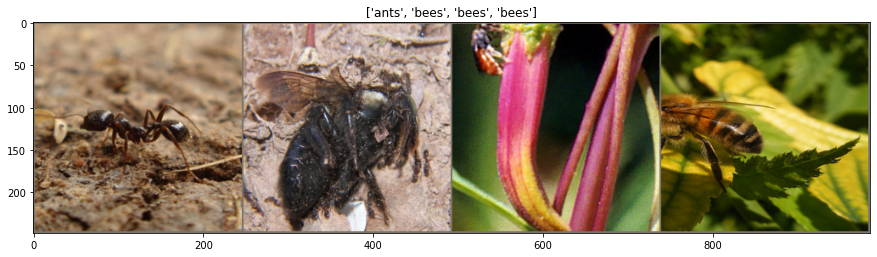

In [6]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(15, 12))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


# Получим 1 батч (картнки-метки) из обучающей выборки
inputs, classes = next(iter(dataloaders['train']))

# Расположим картинки рядом
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [7]:
for i in dataloaders['train']:
    print(i[0][0])
    break

tensor([[[ 0.9132,  0.9132,  0.9303,  ...,  1.1358,  0.9132,  0.8618],
         [ 0.2453,  0.3309,  0.5022,  ...,  0.7933,  0.8104,  0.9303],
         [-0.2856, -0.0629,  0.2282,  ...,  0.4337,  0.6049,  0.8447],
         ...,
         [ 1.3584,  1.4440,  1.6153,  ..., -0.2684, -1.3987, -1.6898],
         [ 1.3584,  1.7694,  1.8550,  ...,  0.2282, -0.8335, -1.4329],
         [ 1.4612,  1.3070,  1.4098,  ...,  0.5022, -0.2684, -0.9534]],

        [[ 0.4678,  0.4853,  0.4853,  ...,  0.7304,  0.5553,  0.5553],
         [-0.0924,  0.0126,  0.1352,  ...,  0.3452,  0.3978,  0.4853],
         [-0.5126, -0.2850, -0.0924,  ...,  0.0126,  0.2052,  0.4153],
         ...,
         [ 0.9755,  1.0630,  1.3256,  ..., -0.3550, -1.3179, -1.7031],
         [ 1.2731,  1.6408,  1.7633,  ...,  0.1352, -0.8102, -1.5280],
         [ 1.3081,  1.2381,  1.3782,  ...,  0.5378, -0.1975, -1.1604]],

        [[ 0.0953,  0.0779,  0.0256,  ...,  0.4614,  0.2696,  0.2522],
         [-0.2881, -0.2010, -0.1835,  ...,  0

Видим, что после обработки данные в батчах нормализованы (то есть они не от 0 до 255, как это изначально в изображениях).

### Обучение моделей

Следующая функция будет использоваться для обучения модели. Аргументы:  
* model $-$ нейросеть
* loss $-$ оптимизируемая функция (criterion, cost function, objective)
* optimizer $-$ оптимизационный алгоритм
* scheduler $-$ алгоритм изменения learning_rate
* num_epochs $-$ количество итераций обучения

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0
    
    losses = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # каждя эпоха имеет обучающую и тестовую стадии
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # установаить модель в режим обучения
            else:
                model.train(False)  # установить модель в режим предсказания

            running_loss = 0.0
            running_corrects = 0

            # итерируемся по батчам
            for data in dataloaders[phase]:
                # получаем картинки и метки
                inputs, labels = data

                # оборачиваем в переменные
                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()
                else:
                    inputs, labels = inputs, labels

                # инициализируем градиенты параметров
                optimizer.zero_grad()

                # forward pass
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)

                # backward pass + оптимизируем только если это стадия обучения
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # статистика
                running_loss += loss.item()
                running_corrects += int(torch.sum(preds == labels.data))

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
            
            losses[phase].append(epoch_loss)
            
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # если достиглось лучшее качество, то запомним веса модели
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # загрузим лучшие веса модели
    model.load_state_dict(best_model_wts)
    return model, losses

Функция для отрисовки тестовых изображений и предсказаний для них:

In [0]:
def visualize_model(model, num_images=6):
    images_so_far = 0
    fig = plt.figure()

    for i, data in enumerate(dataloaders['val']):
        inputs, labels = data
        if use_gpu:
            inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        else:
            inputs, labels = Variable(inputs), Variable(labels)

        outputs = model(inputs)
        _, preds = torch.max(outputs.data, 1)

        for j in range(inputs.size()[0]):
            images_so_far += 1
            ax = plt.subplot(num_images // 2, 2, images_so_far)
            ax.axis('off')
            ax.set_title('predicted: {}'.format(class_names[preds[j]]))
            imshow(inputs.cpu().data[j])

            if images_so_far == num_images:
                return

Функция для измерения точности модели на валидационном датасете

In [0]:
def evaluate(model):
    model.train(False)
    
    runninig_correct = 0
    for data in dataloaders['val']:
        # получаем картинки и метки
        inputs, labels = data
        
        # переносим на GPU, если возможно
        if use_gpu:
            inputs = inputs.cuda()
            labels = labels.cuda()
            
        # forward pass
        output = model(inputs)
        _, predicted = torch.max(output, 1)
        
        runninig_correct += int(torch.sum(predicted == labels))
        
    return runninig_correct / dataset_sizes['val']

### Более современные нейросети (10 баллов)

Теперь Вам предлагается **самостоятельно** сделать Fine Tuning и Transfer Learning для моделей VGG и Inception.

**Суммарно можно получить 10 баллов**.

### VGG16 (2 + 2 = 4 балла)

* **Fine Tuning** способ (2 балла):

In [33]:
model = models.vgg16(pretrained=True)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/checkpoints/vgg16-397923af.pth


In [34]:
model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [35]:
for i, param in enumerate(model.parameters()):
    print(f'Parameter {i}: {param.requires_grad}')

Parameter 0: True
Parameter 1: True
Parameter 2: True
Parameter 3: True
Parameter 4: True
Parameter 5: True
Parameter 6: True
Parameter 7: True
Parameter 8: True
Parameter 9: True
Parameter 10: True
Parameter 11: True
Parameter 12: True
Parameter 13: True
Parameter 14: True
Parameter 15: True
Parameter 16: True
Parameter 17: True
Parameter 18: True
Parameter 19: True
Parameter 20: True
Parameter 21: True
Parameter 22: True
Parameter 23: True
Parameter 24: True
Parameter 25: True
Parameter 26: True
Parameter 27: True
Parameter 28: True
Parameter 29: True
Parameter 30: True
Parameter 31: True


In [0]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [37]:
model, losses = train_model(model, loss_fn, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1916 Acc: 0.6230
val Loss: 0.1375 Acc: 0.7255

Epoch 1/24
----------
train Loss: 0.1624 Acc: 0.6844
val Loss: 0.1707 Acc: 0.6144

Epoch 2/24
----------
train Loss: 0.1672 Acc: 0.5943
val Loss: 0.1330 Acc: 0.7451

Epoch 3/24
----------
train Loss: 0.1432 Acc: 0.7090
val Loss: 0.1019 Acc: 0.8301

Epoch 4/24
----------
train Loss: 0.1303 Acc: 0.7541
val Loss: 0.1111 Acc: 0.8366

Epoch 5/24
----------
train Loss: 0.1103 Acc: 0.8361
val Loss: 0.0949 Acc: 0.8366

Epoch 6/24
----------
train Loss: 0.0712 Acc: 0.9057
val Loss: 0.0891 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.0665 Acc: 0.9180
val Loss: 0.0875 Acc: 0.9020

Epoch 8/24
----------
train Loss: 0.0487 Acc: 0.9180
val Loss: 0.0805 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.0543 Acc: 0.9098
val Loss: 0.0762 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.0481 Acc: 0.9385
val Loss: 0.0706 Acc: 0.9150

Epoch 11/24
----------
train Loss: 0.0345 Acc: 0.9344
val Loss: 0.0760 Acc: 0.9085

Epoch 12/24
----------
t

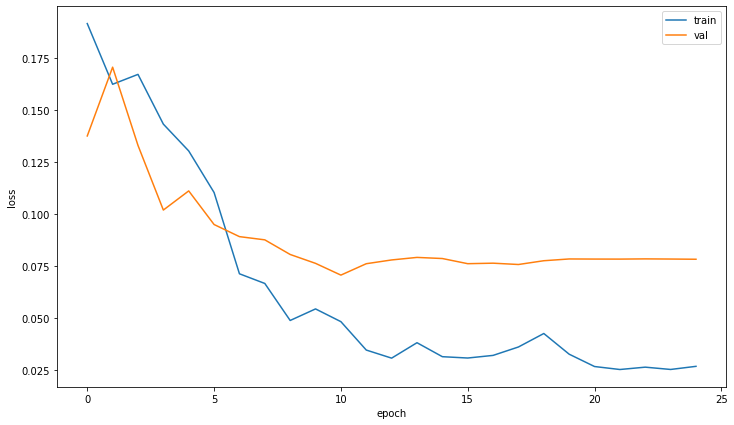

In [38]:
figure = plt.figure(figsize=(12, 7))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend();

In [0]:
torch.save(model.state_dict(), 'VGG16.pth')

In [40]:
model.load_state_dict(torch.load('VGG16.pth'))

<All keys matched successfully>

In [41]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.9150


* **Feature Extractor** способ (2 балла):

In [0]:
model_extractor = models.vgg16(pretrained=True)

In [47]:
model_extractor

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [48]:
for i, param in enumerate(model_extractor.parameters()):
    print(f'Parameter {i}: {param.requires_grad}')

Parameter 0: True
Parameter 1: True
Parameter 2: True
Parameter 3: True
Parameter 4: True
Parameter 5: True
Parameter 6: True
Parameter 7: True
Parameter 8: True
Parameter 9: True
Parameter 10: True
Parameter 11: True
Parameter 12: True
Parameter 13: True
Parameter 14: True
Parameter 15: True
Parameter 16: True
Parameter 17: True
Parameter 18: True
Parameter 19: True
Parameter 20: True
Parameter 21: True
Parameter 22: True
Parameter 23: True
Parameter 24: True
Parameter 25: True
Parameter 26: True
Parameter 27: True
Parameter 28: True
Parameter 29: True
Parameter 30: True
Parameter 31: True


In [0]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 25088
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.classifier = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.classifier.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [50]:
%%time
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.2265 Acc: 0.8607
val Loss: 0.5455 Acc: 0.8431

Epoch 1/24
----------
train Loss: 0.3771 Acc: 0.8893
val Loss: 0.3794 Acc: 0.9281

Epoch 2/24
----------
train Loss: 0.4139 Acc: 0.8770
val Loss: 0.3392 Acc: 0.9477

Epoch 3/24
----------
train Loss: 0.5114 Acc: 0.8852
val Loss: 0.4688 Acc: 0.9216

Epoch 4/24
----------
train Loss: 0.3571 Acc: 0.9221
val Loss: 0.5660 Acc: 0.9346

Epoch 5/24
----------
train Loss: 0.1412 Acc: 0.9467
val Loss: 0.4952 Acc: 0.9346

Epoch 6/24
----------
train Loss: 0.1422 Acc: 0.9508
val Loss: 0.4143 Acc: 0.9412

Epoch 7/24
----------
train Loss: 0.1071 Acc: 0.9508
val Loss: 0.4248 Acc: 0.9346

Epoch 8/24
----------
train Loss: 0.3015 Acc: 0.9344
val Loss: 0.4205 Acc: 0.9346

Epoch 9/24
----------
train Loss: 0.1195 Acc: 0.9508
val Loss: 0.4233 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.2816 Acc: 0.9262
val Loss: 0.4377 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.0841 Acc: 0.9672
val Loss: 0.4199 Acc: 0.9346

Epoch 12/24
----------
t

In [0]:
torch.save(model_extractor.state_dict(), 'VGG16_extractor.pth')

In [52]:
model_extractor.load_state_dict(torch.load('VGG16_extractor.pth'))

<All keys matched successfully>

In [53]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9346


Какой подход оказался лучше с VGG? Сильная ли между ними разница в качестве? Как Вы думаете, почему?

**Способ Feature Extractor улучшил результат на ~1%**

### GoogleNet (Inception) (2 + 2 = 4 балла)

С этой нейросетью нужно сделать то же самое. Код снова можно переиспользовать от AlexNet/VGG, однако стоит учесть, что **слой классификации в Inception называется не `classificator`, а `fc`.**

In [0]:
# Нужно поменять размер картинок на 299, иначе будет ошибка, так как размерность станет отрицательной.
# Это вызвано тем, что нейросеть изначально обучалась на картинках размера 299.

# Результирующий размер картинок определяется трансформациями
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Сам объект датасета
image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x),
        data_transforms[x])
    for x in ['train', 'val']
}

# специальный класс для загрузки данных в виде батчей
dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], 
        batch_size=4,
        shuffle=True, 
        num_workers=4
    )
    for x in ['train', 'val']
}

* **Fine Tuning** способ (2 балла):

In [0]:
model = models.googlenet(pretrained=True)

In [75]:
model

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [0]:
# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1024
# Заменяем Fully-Connected слой на наш линейный классификатор
model.fc = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model = model.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# В качестве оптимизатора - стохастический градиентный спуск
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [77]:
%%time
model.aux_logits = False
model,losses = train_model(model, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1811 Acc: 0.4918
val Loss: 0.1846 Acc: 0.5294

Epoch 1/24
----------
train Loss: 0.1849 Acc: 0.4877
val Loss: 0.1852 Acc: 0.5294

Epoch 2/24
----------
train Loss: 0.1845 Acc: 0.4877
val Loss: 0.1835 Acc: 0.5359

Epoch 3/24
----------
train Loss: 0.1839 Acc: 0.4877
val Loss: 0.1811 Acc: 0.5425

Epoch 4/24
----------
train Loss: 0.1855 Acc: 0.5000
val Loss: 0.1846 Acc: 0.5229

Epoch 5/24
----------
train Loss: 0.1881 Acc: 0.4877
val Loss: 0.1834 Acc: 0.5425

Epoch 6/24
----------
train Loss: 0.1838 Acc: 0.4959
val Loss: 0.1814 Acc: 0.5359

Epoch 7/24
----------
train Loss: 0.1866 Acc: 0.4877
val Loss: 0.1849 Acc: 0.5359

Epoch 8/24
----------
train Loss: 0.1873 Acc: 0.4877
val Loss: 0.1853 Acc: 0.5359

Epoch 9/24
----------
train Loss: 0.1855 Acc: 0.4959
val Loss: 0.1815 Acc: 0.5294

Epoch 10/24
----------
train Loss: 0.1866 Acc: 0.4754
val Loss: 0.1862 Acc: 0.5359

Epoch 11/24
----------
train Loss: 0.1822 Acc: 0.5041
val Loss: 0.1827 Acc: 0.5294

Epoch 12/24
----------
t

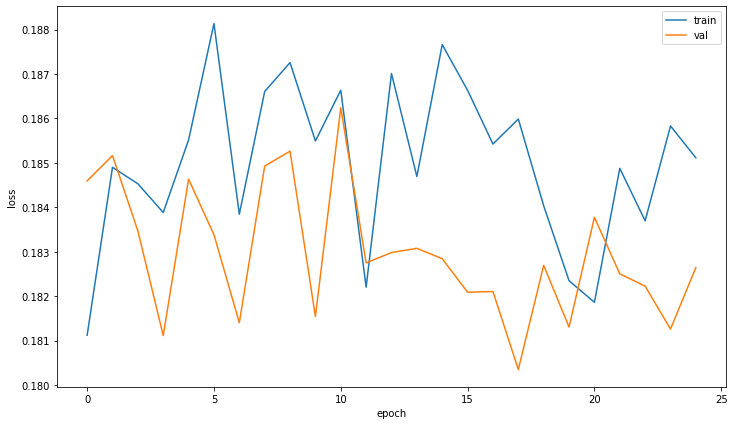

In [78]:
figure = plt.figure(figsize=(12, 7))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend();

In [0]:
torch.save(model.state_dict(), 'GoogleNet.pth')

In [80]:
model.load_state_dict(torch.load('GoogleNet.pth'))

<All keys matched successfully>

In [81]:
print("Accuracy: {0:.4f}".format(evaluate(model)))

Accuracy: 0.5294


* **Feature Extractor** способ (2 балла):

In [0]:
model_extractor = models.googlenet(pretrained=True)

In [83]:
model_extractor

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [84]:
for i, param in enumerate(model_extractor.parameters()):
    print(f'Parameter {i}: {param.requires_grad}')

Parameter 0: True
Parameter 1: True
Parameter 2: True
Parameter 3: True
Parameter 4: True
Parameter 5: True
Parameter 6: True
Parameter 7: True
Parameter 8: True
Parameter 9: True
Parameter 10: True
Parameter 11: True
Parameter 12: True
Parameter 13: True
Parameter 14: True
Parameter 15: True
Parameter 16: True
Parameter 17: True
Parameter 18: True
Parameter 19: True
Parameter 20: True
Parameter 21: True
Parameter 22: True
Parameter 23: True
Parameter 24: True
Parameter 25: True
Parameter 26: True
Parameter 27: True
Parameter 28: True
Parameter 29: True
Parameter 30: True
Parameter 31: True
Parameter 32: True
Parameter 33: True
Parameter 34: True
Parameter 35: True
Parameter 36: True
Parameter 37: True
Parameter 38: True
Parameter 39: True
Parameter 40: True
Parameter 41: True
Parameter 42: True
Parameter 43: True
Parameter 44: True
Parameter 45: True
Parameter 46: True
Parameter 47: True
Parameter 48: True
Parameter 49: True
Parameter 50: True
Parameter 51: True
Parameter 52: True
Par

In [0]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

# num_features -- это размерность вектора фич, поступающего на вход FC-слою
num_features = 1024
# Заменяем Fully-Connected слой на наш линейный классификатор
model_extractor.fc = nn.Linear(num_features, 2)

# Использовать ли GPU
if use_gpu:
    model_extractor = model_extractor.cuda()

# В качестве cost function используем кросс-энтропию
loss_fn = nn.CrossEntropyLoss()

# Обучаем только классификатор
optimizer = optim.SGD(model_extractor.fc.parameters(), lr=0.001, momentum=0.9)

# Умножает learning_rate на 0.1 каждые 7 эпох (это одна из эвристик, не было на лекциях)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [87]:
%%time
model.aux_logits = False
model_extractor,losses = train_model(model_extractor, loss_fn, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1663 Acc: 0.5861
val Loss: 0.1243 Acc: 0.7974

Epoch 1/24
----------
train Loss: 0.1230 Acc: 0.7787
val Loss: 0.0800 Acc: 0.9412

Epoch 2/24
----------
train Loss: 0.1150 Acc: 0.7828
val Loss: 0.0710 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.1108 Acc: 0.8238
val Loss: 0.0633 Acc: 0.9477

Epoch 4/24
----------
train Loss: 0.0990 Acc: 0.8115
val Loss: 0.0576 Acc: 0.9281

Epoch 5/24
----------
train Loss: 0.1084 Acc: 0.7951
val Loss: 0.0544 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.0916 Acc: 0.8361
val Loss: 0.0556 Acc: 0.9346

Epoch 7/24
----------
train Loss: 0.0967 Acc: 0.8238
val Loss: 0.0599 Acc: 0.9216

Epoch 8/24
----------
train Loss: 0.1105 Acc: 0.7623
val Loss: 0.0528 Acc: 0.9412

Epoch 9/24
----------
train Loss: 0.0919 Acc: 0.8402
val Loss: 0.0540 Acc: 0.9412

Epoch 10/24
----------
train Loss: 0.0916 Acc: 0.8074
val Loss: 0.0517 Acc: 0.9346

Epoch 11/24
----------
train Loss: 0.1054 Acc: 0.7705
val Loss: 0.0532 Acc: 0.9412

Epoch 12/24
----------
t

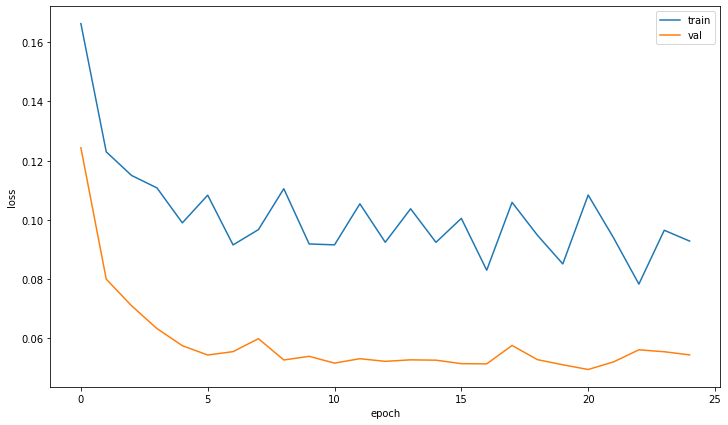

In [88]:
figure = plt.figure(figsize=(12, 7))
plt.xlabel('epoch')
plt.ylabel('loss')
plt.plot(losses['train'], label='train')
plt.plot(losses['val'], label='val')
plt.legend();

In [0]:
torch.save(model_extractor.state_dict(), 'GoogleNet_extractor.pth')

In [90]:
model_extractor.load_state_dict(torch.load('GoogleNet_extractor.pth'))

<All keys matched successfully>

In [91]:
print("Accuracy: {0:.4f}".format(evaluate(model_extractor)))

Accuracy: 0.9412


---

### Выводы (1 + 1 = 2 балла)

(1 балл) Какой подход оказался лучше с GoogleNet: Fine tuning или Feature Extractor? Сильная ли между этими подходами получилась разница в качестве? Как Вы думаете, почему?

**Ответ:**
Наилучшим для гуглонет является подход - feature extractor. Это связано с архитектурой сети - при полном дообучении нарушается качество работы intercept'ов и вспомогательных классификаторов.

(1 балла) Какая модель показала себя лучше всех по метрике качества? С чем это может быть связано?

**Ответ:**
CoogleNet работает наилучшим образом: точность ~ 94%